In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy as np
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import random

%matplotlib inline

In [4]:
calendar = pd.read_csv('./seattle/calendar.csv')
listings = pd.read_csv('./seattle/listings.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

In [137]:
map = gpd.read_file('./seattle/spdbeat_WGS84/spdbeat_WGS84.shp')
#map

In [138]:
map['area_id'] = random.sample(range(len(map)), len(map))

In [142]:
area_map = map[['geometry','AREA_','area_id']]


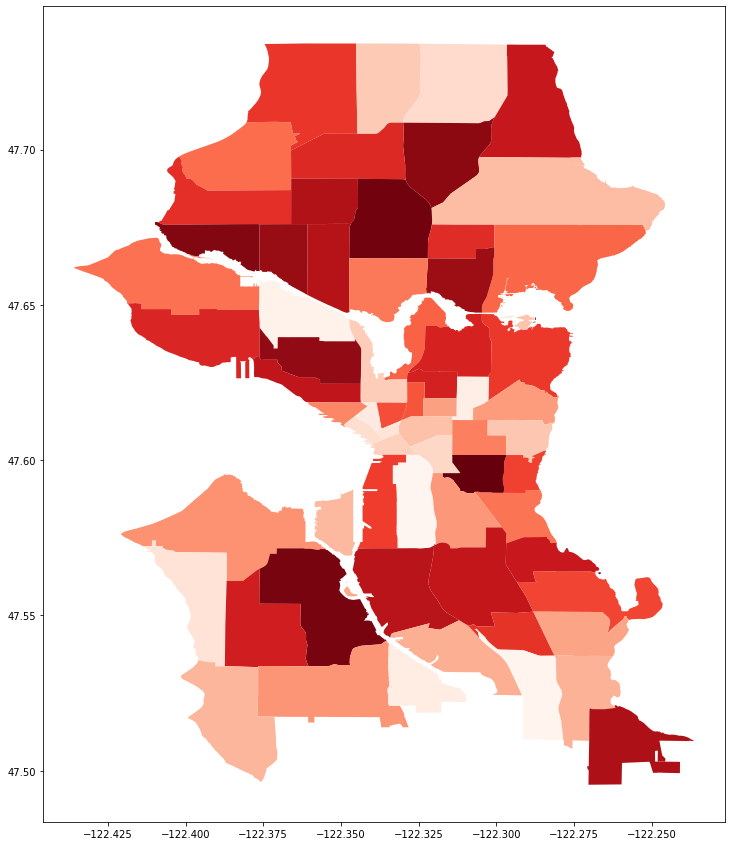

In [133]:
fig,ax = plt.subplots(figsize = (15,15))
map.plot(ax=ax,column='id', cmap = 'Reds');

In [92]:
geometry = [Point(xy) for xy in zip(listings['longitude'],listings['latitude'])]
crs = {'init':'epsg:4326'}

In [93]:
geo_listings = gpd.GeoDataFrame(listings, crs = crs, geometry = geometry )
geo_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,POINT (-122.3710251999777 47.63628903835718)
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,POINT (-122.3656664643958 47.63912312136253)
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,POINT (-122.3694831756176 47.62972413157735)
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,POINT (-122.3692791226302 47.63847320176642)
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,POINT (-122.3724706340222 47.63291840276724)


In [215]:
airbnb_within_area = gpd.sjoin(geo_listings, area_map, how="inner", op='intersects')
airbnb_within_area['price'] = airbnb_within_area['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float64)


In [204]:
airbnb_within_area[airbnb_within_area.unique() == ['t','f']]

AttributeError: 'GeoDataFrame' object has no attribute 'unique'

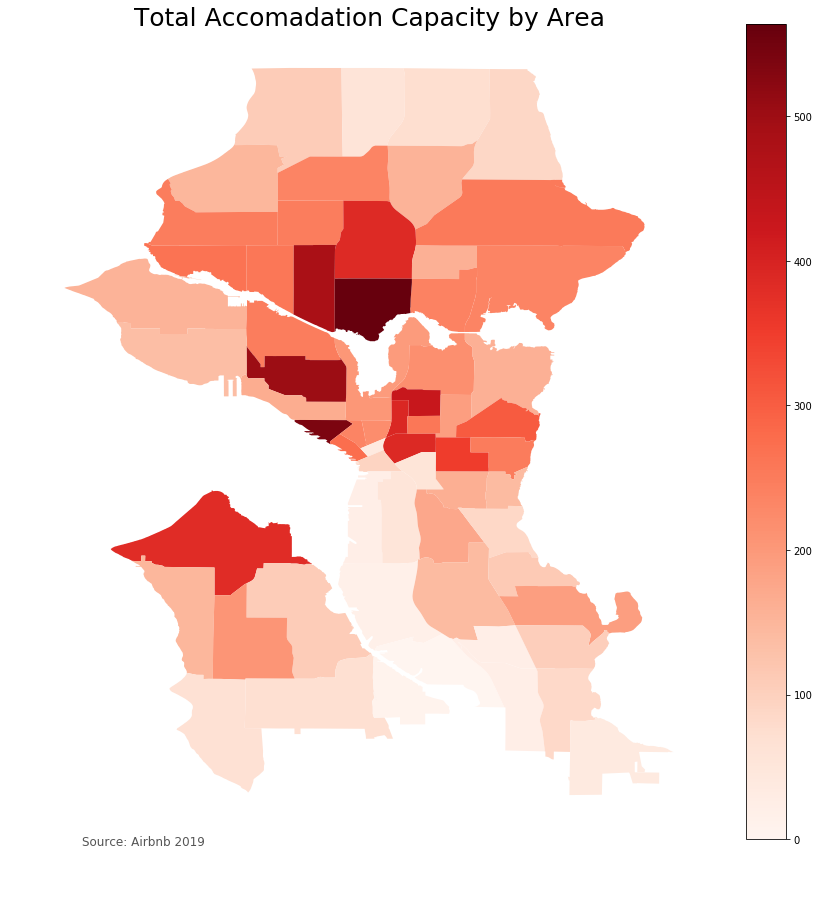

In [225]:
def agg_feat_by_area(df_map, df_feat, feat, colormap, title, agg_type = 'sum'):
    
    if agg_type == 'sum':
        feat_within_area = df_feat[['area_id',feat]].groupby('area_id', as_index = False).sum()
    if agg_type == 'mean':
        feat_within_area = df_feat[['area_id',feat]].groupby('area_id', as_index = False).mean()
        
    feat_map = pd.merge(df_map, feat_within_area, on = 'area_id', how = 'inner')
    
    fig,ax = plt.subplots(figsize = (15,15))
    
    feat_map.plot(ax = ax, column = feat, cmap = colormap);
    
    ax.axis('off')
    
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    ax.annotate('Source: Airbnb 2019',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    
    vmin, vmax = 0, feat_map[feat].max()
    
    sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(vmin=vmin, vmax=vmax))
    
    cbar = fig.colorbar(sm)
    
    return feat_map
    
accommodates_map = agg_feat_by_area(area_map,airbnb_within_area,'accommodates','Reds', 'Total Accomadation Capacity by Area', 'sum')

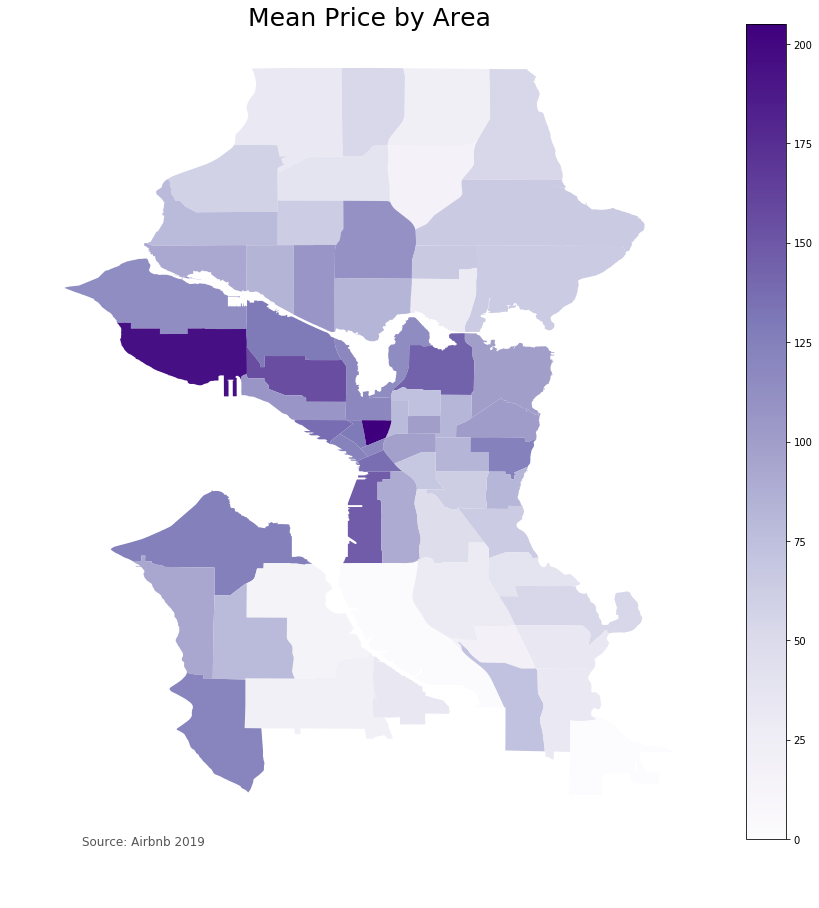

In [222]:
prices_map = agg_feat_by_area(area_map,airbnb_within_area,'price','Purples', 'Mean Price by Area', 'mean')

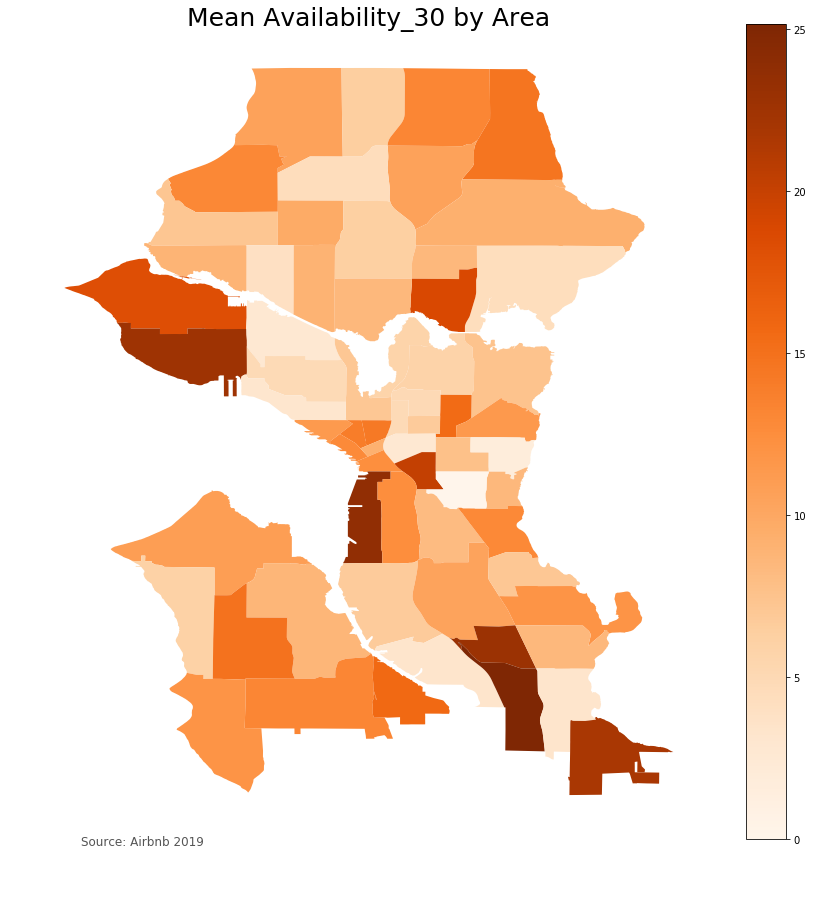

In [229]:
Availability_map = agg_feat_by_area(area_map,airbnb_within_area,'availability_30','Oranges', 'Mean Availability_30 by Area', 'mean')

# Calendar 

# Reviews

In [146]:
listings.keys()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [173]:
listings.accommodates

0        4
1        4
2       11
3        3
4        6
5        2
6        2
7        2
8        2
9        4
10       2
11       2
12       4
13       5
14      16
15       5
16       2
17       2
18       2
19      10
20       1
21       3
22       8
23       2
24       5
25       8
26       5
27       2
28       6
29       3
        ..
3788     4
3789     2
3790     6
3791     2
3792     4
3793     4
3794     2
3795     4
3796     2
3797     2
3798     2
3799     2
3800     2
3801     2
3802     4
3803    16
3804     2
3805     6
3806     4
3807     2
3808     6
3809     4
3810     5
3811     3
3812     4
3813     6
3814     4
3815     2
3816     2
3817     3
Name: accommodates, Length: 3818, dtype: int64

In [62]:
listings_copy = listings.copy()

listings_copy['price'] = listings_copy['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float64)


mean_price_by_neighbourhood = listings_copy[['neighbourhood','price']].groupby('neighbourhood').mean()
mean_price_by_neighbourhood

,price
neighbourhood,
Alki,196.652174
Arbor Heights,118.000000
Atlantic,116.280000
Ballard,123.615023
Belltown,166.627451
Bitter Lake,78.846154
Brighton,78.000000
Broadview,102.875000
Broadway,128.400000
